# Teste Cognitivo A.I.
#### Solução : Gabriel Novais

### Importando os Pacotes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras 
import tensorflow
import theano
import sys
import seaborn as sns
import warnings

from sklearn.metrics import fbeta_score, accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense,Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV

/home/novais/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%load_ext autotime
%matplotlib inline
warnings.filterwarnings("ignore")

### Função Medida

In [3]:
def medida(modelo, X_test, y_test):
    pred = modelo.predict(X_test)
    errors = abs(pred - y_test)**2
    media = np.mean(errors)
    mape = 100 * np.mean(errors / y_test)
    acc = 100 - mape
    print('MSE: {:0.2f}%.'.format(media))
    print('Accuracy = {:0.2f}%.'.format(acc))
    
    return acc,media

time: 98 ms


### Importando os Dados

In [4]:
vinhos = pd.read_csv("winequality.csv",delimiter=';',dtype=str)
vinhos.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,White,7,0.27,0.36,20.7,0.045,45,170,1.001,3,0.45,8.8,6
1,White,6.3,0.3,0.34,1.6,0.049,14,132,0.994,3.3,0.49,9.5,6
2,White,8.1,0.28,0.4,6.9,0.05,30,97,0.9951,3.26,0.44,10.1,6
3,White,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6
4,White,7.2,0.23,0.32,8.5,0.058,47,186,0.9956,3.19,0.4,9.9,6


time: 146 ms


### Corrigindo Erros nos Dados

In [5]:
#Alcohol apresentou erro de preechimento
for column in vinhos.columns[1:]:
    vinhos[column] = vinhos[column].apply(lambda x: float(x) if len(x.split('.'))<3 else 'ERRO')
perdas = vinhos[vinhos['alcohol']== 'ERRO'].shape[0]
vinhos = vinhos[vinhos['alcohol']!= 'ERRO'].reset_index(drop=True)
vinhos['alcohol'] = vinhos['alcohol'].astype(float)
print("Total de erros em alcohol : "+str(perdas))
print("Dados Corrigidos")

Total de erros em alcohol : 40
Dados Corrigidos
time: 247 ms


### Análise exploratória dos Dados

In [6]:
vinhos_obs = vinhos

time: 1.07 ms


In [7]:
#Transformando type em dummy (White = 1, Red = 0):
labelencoder= LabelEncoder()
vinhos_obs['type']=labelencoder.fit_transform(vinhos_obs['type'])
vinhos_obs.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0


time: 132 ms


In [8]:
vinhos_obs.groupby('type').count()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
type,,,,,,,,,,,,
0,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593,1593
1,4864,4864,4864,4864,4864,4864,4864,4864,4864,4864,4864,4864


time: 67.7 ms


In [9]:
vinhos.describe()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000,6457.000000
mean,0.753291,7.219475,0.339684,0.318795,5.445973,0.056081,30.495586,115.690801,1.715329,3.218592,0.531169,10.489083,5.817098
std,0.431129,1.294910,0.164690,0.145506,4.764308,0.035110,17.757007,56.595196,7.659497,0.160845,0.148870,1.192961,0.874125
min,0.000000,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,1.000000,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992350,3.110000,0.430000,9.500000,5.000000
50%,1.000000,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994900,3.210000,0.510000,10.300000,6.000000
75%,1.000000,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.997000,3.320000,0.600000,11.300000,6.000000
max,1.000000,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,103.898000,4.010000,2.000000,14.900000,9.000000


time: 165 ms


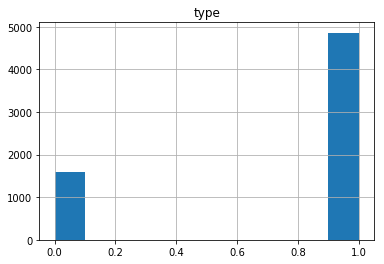

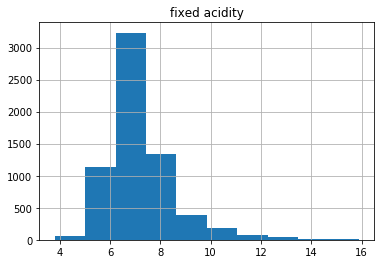

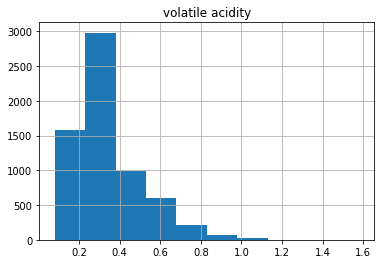

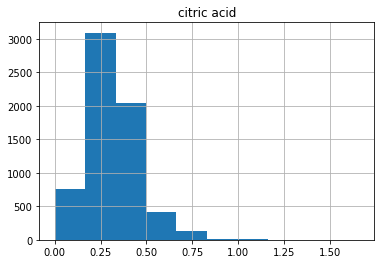

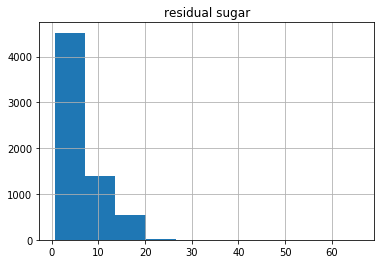

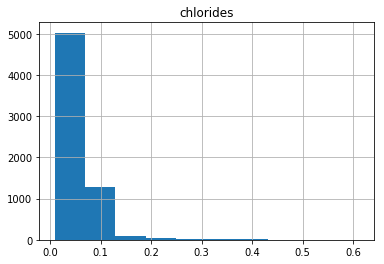

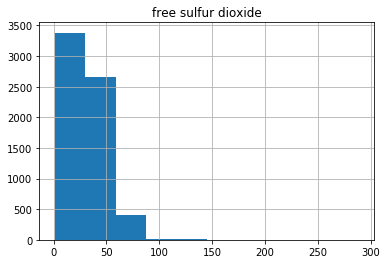

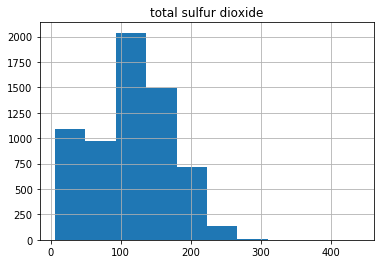

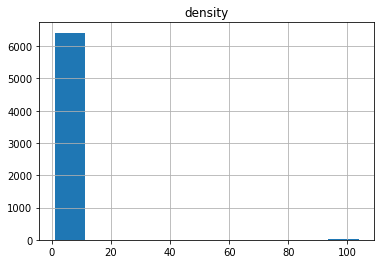

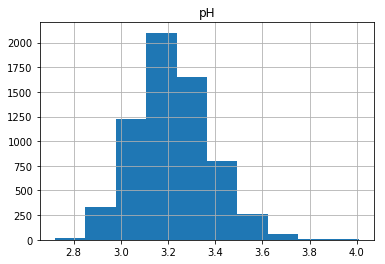

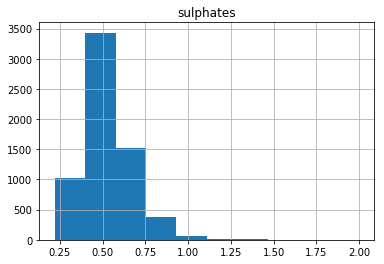

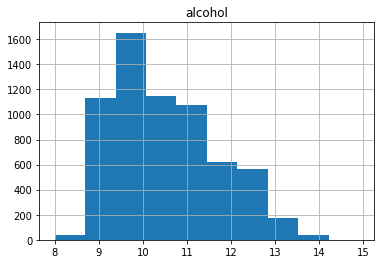

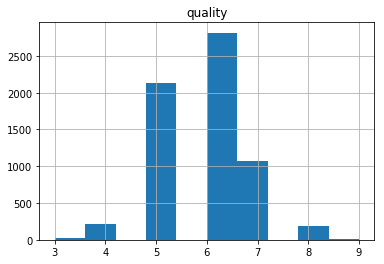

time: 2.53 s


In [10]:
hist_Type = vinhos.hist('type')
hist_FixedAcidity = vinhos.hist('fixed acidity')
hist_VolatileAcidity = vinhos.hist('volatile acidity')
hist_CitricAcid = vinhos.hist('citric acid')
hist_ResidualSugar = vinhos.hist('residual sugar')
hist_Chlorides = vinhos.hist('chlorides')
hist_FreeSulfurDioxide = vinhos.hist('free sulfur dioxide')
hist_TotalSulfurDioxide = vinhos.hist('total sulfur dioxide')
hist_Density = vinhos.hist('density')
hist_Ph = vinhos.hist('pH')
hist_Sulphates = vinhos.hist('sulphates')
hist_Alcohol = vinhos.hist('alcohol')
hist_Quality = vinhos.hist('quality')

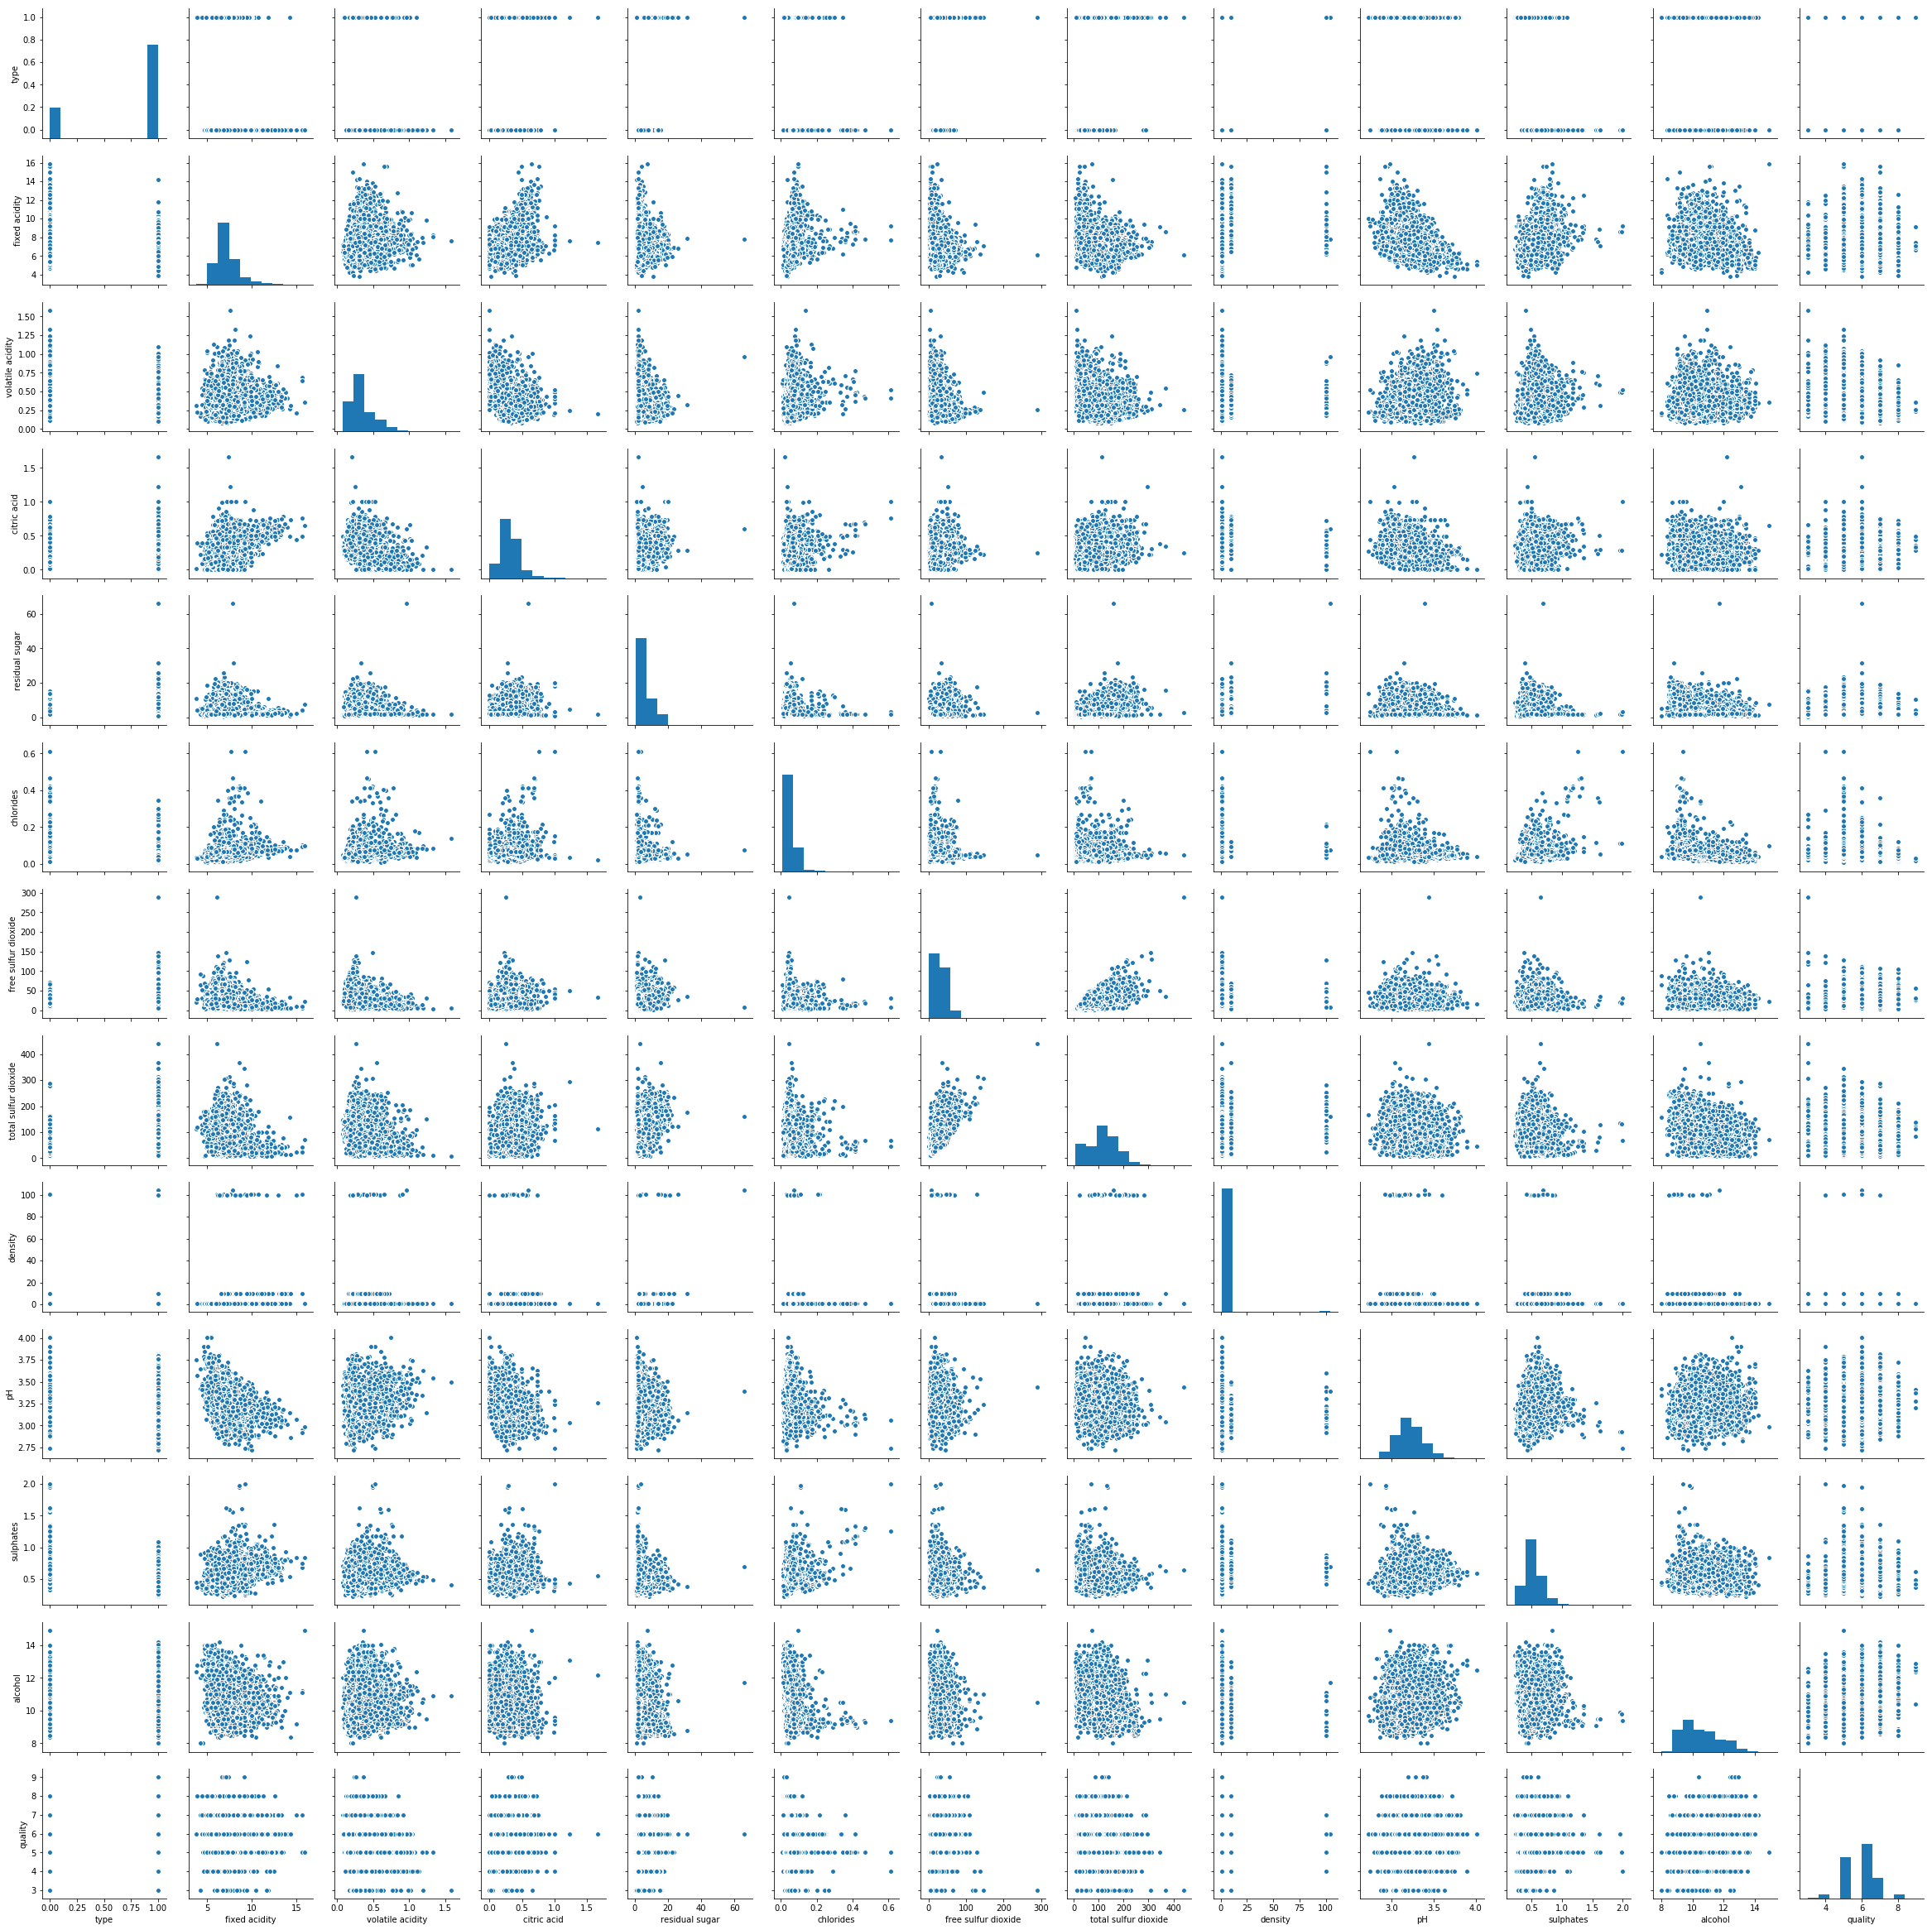

time: 24 s


In [11]:
sns.pairplot(vinhos_obs)
plt.show()

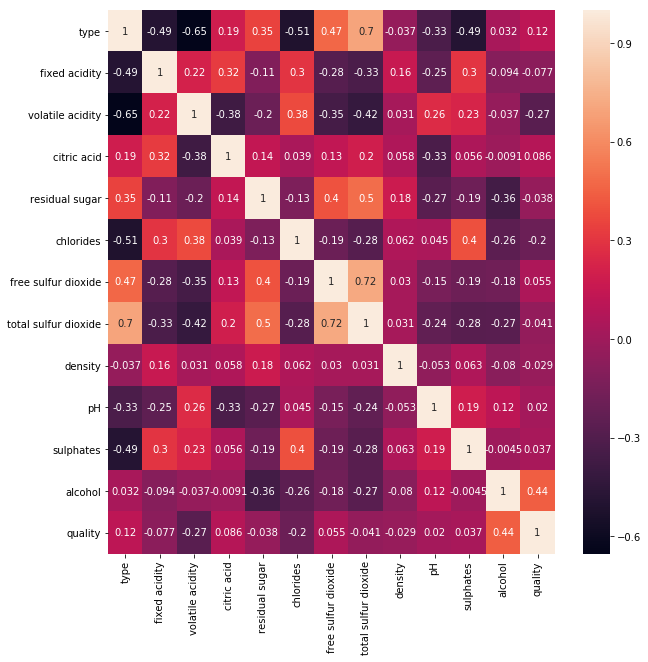

time: 1.23 s


In [12]:
Var_Corr = vinhos_obs.corr()
fig,ax = plt.subplots(figsize = (10,10))
sns.heatmap(Var_Corr, xticklabels=Var_Corr.columns, yticklabels=Var_Corr.columns, annot=True, ax = ax)
plt.show()

### Preparando os Dados (ANN)

In [13]:
X = vinhos_obs.iloc[:,1:-1].values
y = vinhos_obs.iloc[:,-1].values

time: 2.06 ms


In [14]:
max1 = max(X[:,0])
onehotencoder_X = OneHotEncoder(categorical_features = [0], n_values= [max1+1])
X = onehotencoder_X.fit_transform(X).toarray()
onehotencoder_y = OneHotEncoder(categorical_features = [0])
y = onehotencoder_y.fit_transform(y.reshape((-1,1))).toarray()
X = pd.DataFrame(X)
X = X.drop([0], axis = 1)
X = X.iloc[:,:].values

time: 89.4 ms


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Total de observações : '+str(len(X)))
print('Total de observações do treinamento : ' + str(len(X_train)))
print('Total de observações do teste : ' + str(len(X_test)))

Total de observações : 6457
Total de observações do treinamento : 5165
Total de observações do teste : 1292
time: 92.4 ms


In [16]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

time: 197 ms


### Método 1 : Artificial Neural Networks (ANN)

In [17]:
neurons  = round((X.shape[1] + y.shape[1])/2)
n_layers = 10
classifier = Sequential()
classifier.add(Dense(units = neurons,kernel_initializer = 'uniform',activation = 'relu',input_shape = (X.shape[1],)))
for layer in range(n_layers):
    classifier.add(Dense(units = neurons,kernel_initializer = 'uniform',activation = 'relu'))
classifier.add(Dense(units=y.shape[1],kernel_initializer='uniform',activation='softmax'))
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train, y_train, batch_size = 10, epochs = 100)

Epoch 1/100
5165/5165 [==============================] - 5s 932us/step - loss: 1.3964 - acc: 0.4283
Epoch 2/100
5165/5165 [==============================] - 2s 467us/step - loss: 1.2582 - acc: 0.4370
Epoch 3/100
5165/5165 [==============================] - 3s 545us/step - loss: 1.2436 - acc: 0.4439
Epoch 4/100
5165/5165 [==============================] - 3s 548us/step - loss: 1.2282 - acc: 0.4548
Epoch 5/100
5165/5165 [==============================] - 3s 503us/step - loss: 1.2029 - acc: 0.4796
Epoch 6/100
5165/5165 [==============================] - 2s 481us/step - loss: 1.1704 - acc: 0.5154
Epoch 7/100
5165/5165 [==============================] - 3s 513us/step - loss: 1.1353 - acc: 0.5138
Epoch 8/100
5165/5165 [==============================] - 2s 460us/step - loss: 1.1044 - acc: 0.5262
Epoch 9/100
5165/5165 [==============================] - 2s 481us/step - loss: 1.0883 - acc: 0.5262
Epoch 10/100
5165/5165 [==============================] - 2s 477us/step - loss: 1.0806 - acc: 0.5371

5165/5165 [==============================] - 2s 458us/step - loss: 0.9701 - acc: 0.5959
Epoch 83/100
5165/5165 [==============================] - 2s 446us/step - loss: 0.9716 - acc: 0.5917
Epoch 84/100
5165/5165 [==============================] - 2s 448us/step - loss: 0.9711 - acc: 0.5944
Epoch 85/100
5165/5165 [==============================] - 2s 469us/step - loss: 0.9707 - acc: 0.5930
Epoch 86/100
5165/5165 [==============================] - 2s 467us/step - loss: 0.9679 - acc: 0.6004
Epoch 87/100
5165/5165 [==============================] - 2s 452us/step - loss: 0.9680 - acc: 0.5998
Epoch 88/100
5165/5165 [==============================] - 2s 473us/step - loss: 0.9687 - acc: 0.5986
Epoch 89/100
5165/5165 [==============================] - 2s 455us/step - loss: 0.9692 - acc: 0.5992
Epoch 90/100
5165/5165 [==============================] - 2s 474us/step - loss: 0.9699 - acc: 0.5942
Epoch 91/100
5165/5165 [==============================] - 2s 472us/step - loss: 0.9679 - acc: 0.6023
Epo

time: 4min 22s


In [18]:
def build_classifier():
    neurons  = round((X.shape[1] + y.shape[1])/2)
    n_layers = 12
    classifier = Sequential()
    classifier.add(Dense(units = neurons,kernel_initializer = 'uniform',activation = 'relu',input_shape = (X.shape[1],)))
    for layer in range(n_layers):
        classifier.add(Dense(units = neurons,kernel_initializer = 'uniform',activation = 'relu'))
    classifier.add(Dense(units=y.shape[1],kernel_initializer='uniform',activation='softmax'))
    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return classifier

time: 4.65 ms


In [19]:
classifier  = KerasClassifier(build_fn = build_classifier, batch_size = 10, epochs = 100)

time: 134 ms


In [20]:
accuracies  = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10, n_jobs = 1)

Epoch 1/100
4648/4648 [==============================] - 4s 829us/step - loss: 1.3973 - acc: 0.4344
Epoch 2/100
4648/4648 [==============================] - 2s 503us/step - loss: 1.2679 - acc: 0.4361
Epoch 3/100
4648/4648 [==============================] - 2s 520us/step - loss: 1.2505 - acc: 0.4292
Epoch 4/100
4648/4648 [==============================] - 2s 501us/step - loss: 1.2389 - acc: 0.4438
Epoch 5/100
4648/4648 [==============================] - 2s 486us/step - loss: 1.2150 - acc: 0.4664
Epoch 6/100
4648/4648 [==============================] - 2s 478us/step - loss: 1.1966 - acc: 0.4800
Epoch 7/100
4648/4648 [==============================] - 2s 482us/step - loss: 1.1645 - acc: 0.5032
Epoch 8/100
4648/4648 [==============================] - 2s 505us/step - loss: 1.1385 - acc: 0.5161
Epoch 9/100
4648/4648 [==============================] - 2s 536us/step - loss: 1.1152 - acc: 0.5217
Epoch 10/100
4648/4648 [==============================] - 2s 516us/step - loss: 1.0995 - acc: 0.5219

4648/4648 [==============================] - 2s 503us/step - loss: 0.9625 - acc: 0.6028
Epoch 83/100
4648/4648 [==============================] - 2s 478us/step - loss: 0.9621 - acc: 0.6067
Epoch 84/100
4648/4648 [==============================] - 2s 484us/step - loss: 0.9682 - acc: 0.6009
Epoch 85/100
4648/4648 [==============================] - 2s 483us/step - loss: 0.9620 - acc: 0.5985
Epoch 86/100
4648/4648 [==============================] - 2s 473us/step - loss: 0.9597 - acc: 0.6076
Epoch 87/100
4648/4648 [==============================] - 2s 500us/step - loss: 0.9623 - acc: 0.6015
Epoch 88/100
4648/4648 [==============================] - 2s 488us/step - loss: 0.9594 - acc: 0.6080
Epoch 89/100
4648/4648 [==============================] - 2s 477us/step - loss: 0.9619 - acc: 0.6046
Epoch 90/100
4648/4648 [==============================] - 2s 497us/step - loss: 0.9610 - acc: 0.6093
Epoch 91/100
4648/4648 [==============================] - 2s 501us/step - loss: 0.9553 - acc: 0.6104
Epo

4648/4648 [==============================] - 2s 500us/step - loss: 0.9740 - acc: 0.5975
Epoch 63/100
4648/4648 [==============================] - 2s 484us/step - loss: 0.9736 - acc: 0.6037
Epoch 64/100
4648/4648 [==============================] - 2s 486us/step - loss: 0.9720 - acc: 0.6007
Epoch 65/100
4648/4648 [==============================] - 2s 501us/step - loss: 0.9732 - acc: 0.5990
Epoch 66/100
4648/4648 [==============================] - 2s 504us/step - loss: 0.9715 - acc: 0.6048
Epoch 67/100
4648/4648 [==============================] - 2s 506us/step - loss: 0.9684 - acc: 0.6050
Epoch 68/100
4648/4648 [==============================] - 2s 496us/step - loss: 0.9672 - acc: 0.6084
Epoch 69/100
4648/4648 [==============================] - 2s 488us/step - loss: 0.9696 - acc: 0.6013
Epoch 70/100
4648/4648 [==============================] - 2s 504us/step - loss: 0.9663 - acc: 0.6031
Epoch 71/100
4648/4648 [==============================] - 2s 513us/step - loss: 0.9673 - acc: 0.6039
Epo

4648/4648 [==============================] - 2s 536us/step - loss: 1.0228 - acc: 0.5514
Epoch 43/100
4648/4648 [==============================] - 2s 519us/step - loss: 1.0240 - acc: 0.5503
Epoch 44/100
4648/4648 [==============================] - 2s 527us/step - loss: 1.0219 - acc: 0.5574
Epoch 45/100
4648/4648 [==============================] - 2s 526us/step - loss: 1.0221 - acc: 0.5568
Epoch 46/100
4648/4648 [==============================] - 2s 517us/step - loss: 1.0195 - acc: 0.5549
Epoch 47/100
4648/4648 [==============================] - 2s 521us/step - loss: 1.0200 - acc: 0.5605
Epoch 48/100
4648/4648 [==============================] - 2s 536us/step - loss: 1.0166 - acc: 0.5607
Epoch 49/100
4648/4648 [==============================] - 2s 537us/step - loss: 1.0192 - acc: 0.5592
Epoch 50/100
4648/4648 [==============================] - 2s 531us/step - loss: 1.0204 - acc: 0.5542
Epoch 51/100
4648/4648 [==============================] - 2s 535us/step - loss: 1.0179 - acc: 0.5637
Epo

4648/4648 [==============================] - 2s 400us/step - loss: 1.0438 - acc: 0.5527
Epoch 23/100
4648/4648 [==============================] - 2s 387us/step - loss: 1.0423 - acc: 0.5534
Epoch 24/100
4648/4648 [==============================] - 2s 397us/step - loss: 1.0384 - acc: 0.5538
Epoch 25/100
4648/4648 [==============================] - 2s 394us/step - loss: 1.0372 - acc: 0.5650
Epoch 26/100
4648/4648 [==============================] - 2s 394us/step - loss: 1.0401 - acc: 0.5559
Epoch 27/100
4648/4648 [==============================] - 2s 403us/step - loss: 1.0393 - acc: 0.5544
Epoch 28/100
4648/4648 [==============================] - 2s 397us/step - loss: 1.0339 - acc: 0.5581
Epoch 29/100
4648/4648 [==============================] - 2s 399us/step - loss: 1.0320 - acc: 0.5615
Epoch 30/100
4648/4648 [==============================] - 2s 396us/step - loss: 1.0311 - acc: 0.5645
Epoch 31/100
4648/4648 [==============================] - 2s 393us/step - loss: 1.0299 - acc: 0.5643
Epo

4648/4648 [==============================] - 2s 413us/step - loss: 1.2737 - acc: 0.4312
Epoch 3/100
4648/4648 [==============================] - 2s 417us/step - loss: 1.2578 - acc: 0.4331
Epoch 4/100
4648/4648 [==============================] - 2s 412us/step - loss: 1.2451 - acc: 0.4387
Epoch 5/100
4648/4648 [==============================] - 2s 414us/step - loss: 1.2320 - acc: 0.4634
Epoch 6/100
4648/4648 [==============================] - 2s 414us/step - loss: 1.2159 - acc: 0.4529
Epoch 7/100
4648/4648 [==============================] - 2s 405us/step - loss: 1.2009 - acc: 0.4770
Epoch 8/100
4648/4648 [==============================] - 2s 404us/step - loss: 1.1869 - acc: 0.4864
Epoch 9/100
4648/4648 [==============================] - 2s 413us/step - loss: 1.1637 - acc: 0.5045
Epoch 10/100
4648/4648 [==============================] - 2s 414us/step - loss: 1.1503 - acc: 0.5108
Epoch 11/100
4648/4648 [==============================] - 2s 408us/step - loss: 1.1342 - acc: 0.5183
Epoch 12/1

4648/4648 [==============================] - 2s 420us/step - loss: 0.9803 - acc: 0.5908
Epoch 84/100
4648/4648 [==============================] - 2s 407us/step - loss: 0.9842 - acc: 0.5880
Epoch 85/100
4648/4648 [==============================] - 2s 407us/step - loss: 0.9837 - acc: 0.5873
Epoch 86/100
4648/4648 [==============================] - 2s 453us/step - loss: 0.9805 - acc: 0.5908
Epoch 87/100
4648/4648 [==============================] - 2s 416us/step - loss: 0.9809 - acc: 0.5957
Epoch 88/100
4648/4648 [==============================] - 2s 413us/step - loss: 0.9876 - acc: 0.5891
Epoch 89/100
4648/4648 [==============================] - 2s 421us/step - loss: 0.9813 - acc: 0.5964
Epoch 90/100
4648/4648 [==============================] - 2s 409us/step - loss: 0.9818 - acc: 0.5970
Epoch 91/100
4648/4648 [==============================] - 2s 426us/step - loss: 0.9768 - acc: 0.5914
Epoch 92/100
4648/4648 [==============================] - 2s 412us/step - loss: 0.9757 - acc: 0.5953
Epo

4649/4649 [==============================] - 2s 416us/step - loss: 0.9863 - acc: 0.5928
Epoch 64/100
4649/4649 [==============================] - 2s 406us/step - loss: 0.9851 - acc: 0.5939
Epoch 65/100
4649/4649 [==============================] - 2s 412us/step - loss: 0.9835 - acc: 0.5928
Epoch 66/100
4649/4649 [==============================] - 2s 412us/step - loss: 0.9816 - acc: 0.5965
Epoch 67/100
4649/4649 [==============================] - 2s 410us/step - loss: 0.9811 - acc: 0.5945
Epoch 68/100
4649/4649 [==============================] - 2s 409us/step - loss: 0.9854 - acc: 0.5980
Epoch 69/100
4649/4649 [==============================] - 2s 402us/step - loss: 0.9796 - acc: 0.6018
Epoch 70/100
4649/4649 [==============================] - 2s 414us/step - loss: 0.9814 - acc: 0.6016
Epoch 71/100
4649/4649 [==============================] - 2s 410us/step - loss: 0.9758 - acc: 0.6081
Epoch 72/100
4649/4649 [==============================] - 2s 412us/step - loss: 0.9794 - acc: 0.6018
Epo

4649/4649 [==============================] - 2s 437us/step - loss: 0.9976 - acc: 0.5846
Epoch 44/100
4649/4649 [==============================] - 2s 430us/step - loss: 0.9963 - acc: 0.5868
Epoch 45/100
4649/4649 [==============================] - 2s 429us/step - loss: 0.9951 - acc: 0.5926
Epoch 46/100
4649/4649 [==============================] - 2s 428us/step - loss: 0.9934 - acc: 0.5896
Epoch 47/100
4649/4649 [==============================] - 2s 435us/step - loss: 0.9950 - acc: 0.5883
Epoch 48/100
4649/4649 [==============================] - 2s 424us/step - loss: 0.9897 - acc: 0.5861
Epoch 49/100
4649/4649 [==============================] - 2s 452us/step - loss: 0.9949 - acc: 0.5894
Epoch 50/100
4649/4649 [==============================] - 2s 431us/step - loss: 0.9909 - acc: 0.5948
Epoch 51/100
4649/4649 [==============================] - 2s 428us/step - loss: 0.9874 - acc: 0.5915
Epoch 52/100
4649/4649 [==============================] - 2s 442us/step - loss: 0.9854 - acc: 0.5937
Epo

4649/4649 [==============================] - 2s 457us/step - loss: 1.0506 - acc: 0.5575
Epoch 24/100
4649/4649 [==============================] - 2s 440us/step - loss: 1.0496 - acc: 0.5558
Epoch 25/100
4649/4649 [==============================] - 2s 439us/step - loss: 1.0472 - acc: 0.5545
Epoch 26/100
4649/4649 [==============================] - 2s 446us/step - loss: 1.0509 - acc: 0.5569
Epoch 27/100
4649/4649 [==============================] - 2s 454us/step - loss: 1.0473 - acc: 0.5550
Epoch 28/100
4649/4649 [==============================] - 2s 450us/step - loss: 1.0462 - acc: 0.5575
Epoch 29/100
4649/4649 [==============================] - 2s 443us/step - loss: 1.0450 - acc: 0.5610
Epoch 30/100
4649/4649 [==============================] - 2s 441us/step - loss: 1.0449 - acc: 0.5575
Epoch 31/100
4649/4649 [==============================] - 2s 441us/step - loss: 1.0447 - acc: 0.5569
Epoch 32/100
4649/4649 [==============================] - 2s 446us/step - loss: 1.0406 - acc: 0.5603
Epo

4649/4649 [==============================] - 2s 475us/step - loss: 1.2471 - acc: 0.4334
Epoch 4/100
4649/4649 [==============================] - 2s 475us/step - loss: 1.2298 - acc: 0.4539
Epoch 5/100
4649/4649 [==============================] - 2s 469us/step - loss: 1.2131 - acc: 0.4844
Epoch 6/100
4649/4649 [==============================] - 2s 460us/step - loss: 1.1922 - acc: 0.5031
Epoch 7/100
4649/4649 [==============================] - 2s 463us/step - loss: 1.1671 - acc: 0.5113
Epoch 8/100
4649/4649 [==============================] - 2s 480us/step - loss: 1.1442 - acc: 0.5283
Epoch 9/100
4649/4649 [==============================] - 2s 471us/step - loss: 1.1252 - acc: 0.5257
Epoch 10/100
4649/4649 [==============================] - 2s 477us/step - loss: 1.1117 - acc: 0.5291
Epoch 11/100
4649/4649 [==============================] - 2s 472us/step - loss: 1.0993 - acc: 0.5319
Epoch 12/100
4649/4649 [==============================] - 2s 468us/step - loss: 1.0928 - acc: 0.5352
Epoch 13/

4649/4649 [==============================] - 2s 472us/step - loss: 0.9618 - acc: 0.6064
Epoch 85/100
4649/4649 [==============================] - 2s 464us/step - loss: 0.9604 - acc: 0.6096
Epoch 86/100
4649/4649 [==============================] - 2s 464us/step - loss: 0.9582 - acc: 0.6021
Epoch 87/100
4649/4649 [==============================] - 2s 473us/step - loss: 0.9582 - acc: 0.6070
Epoch 88/100
4649/4649 [==============================] - 2s 514us/step - loss: 0.9539 - acc: 0.6107
Epoch 89/100
4649/4649 [==============================] - 2s 475us/step - loss: 0.9544 - acc: 0.6092
Epoch 90/100
4649/4649 [==============================] - 2s 477us/step - loss: 0.9545 - acc: 0.6100
Epoch 91/100
4649/4649 [==============================] - 2s 465us/step - loss: 0.9507 - acc: 0.6126
Epoch 92/100
4649/4649 [==============================] - 2s 476us/step - loss: 0.9505 - acc: 0.6126
Epoch 93/100
4649/4649 [==============================] - 2s 475us/step - loss: 0.9544 - acc: 0.6122
Epo

4649/4649 [==============================] - 2s 488us/step - loss: 1.2749 - acc: 0.4358
Epoch 65/100
4649/4649 [==============================] - 2s 490us/step - loss: 1.2745 - acc: 0.4358
Epoch 66/100
4649/4649 [==============================] - 2s 479us/step - loss: 1.2747 - acc: 0.4358
Epoch 67/100
4649/4649 [==============================] - 2s 474us/step - loss: 1.2745 - acc: 0.4358
Epoch 68/100
4649/4649 [==============================] - 2s 495us/step - loss: 1.2748 - acc: 0.4358
Epoch 69/100
4649/4649 [==============================] - 2s 483us/step - loss: 1.2748 - acc: 0.4358
Epoch 70/100
4649/4649 [==============================] - 2s 492us/step - loss: 1.2747 - acc: 0.4358
Epoch 71/100
4649/4649 [==============================] - 2s 486us/step - loss: 1.2740 - acc: 0.4358
Epoch 72/100
4649/4649 [==============================] - 2s 490us/step - loss: 1.2745 - acc: 0.4358
Epoch 73/100
4649/4649 [==============================] - 2s 497us/step - loss: 1.2743 - acc: 0.4358
Epo

In [21]:
mean = accuracies.mean()
std  = accuracies.std()
mean, 2*std
print("Mean : " + str("{0:.2f}".format(mean*100))+"%")
print("Variance : " + str("{0:.2f}".format(std*100))+"%")

Mean : 54.52%
Variance : 4.17%
time: 4.03 ms


### Preparando os dados (GNB, MLR, RTC, DTC)

In [22]:
X = vinhos_obs.iloc[:,1:-1].values
y = vinhos_obs.iloc[:,-1].values

time: 130 ms


In [23]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

time: 119 ms


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print('Total de observações : '+str(len(X)))
print('Total de observações do treinamento : ' + str(len(X_train)))
print('Total de observações do teste : ' + str(len(X_test)))

Total de observações : 6457
Total de observações do treinamento : 5165
Total de observações do teste : 1292
time: 76.3 ms


### Método 2 : Gaussian Naive Bayes (GNB) 

In [25]:
param_grid_GNB = {
    'priors': [None],
    'var_smoothing': [1e-09,1e-05]
}

time: 87.1 ms


In [26]:
GNB = GaussianNB()

time: 105 ms


In [27]:
grid_search_GNB = GridSearchCV(estimator = GNB, param_grid = param_grid_GNB, cv = 10, verbose = 2)

time: 86.1 ms


In [28]:
grid_search_GNB.fit(X_train, y_train)
best_params = grid_search_GNB.best_params_
best_grid_GNB = grid_search_GNB.best_estimator_

Fitting 10 folds for each of 2 candidates, totalling 20 fits
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ................. priors=None, var_smoothing=1e-09, total=   0.0s
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ................. priors=None, var_smoothing=1e-09, total=   0.0s
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ................. priors=None, var_smoothing=1e-09, total=   0.0s
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ................. priors=None, var_smoothing=1e-09, total=   0.0s
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ................. priors=None, var_smoothing=1e-09, total=   0.0s
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ................. priors=None, var_smoothing=1e-09, total=   0.0s
[CV] priors=None, var_smoothing=1e-09 ................................
[CV] ...........

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ................. priors=None, var_smoothing=1e-05, total=   0.0s
[CV] priors=None, var_smoothing=1e-05 ................................
[CV] ................. priors=None, var_smoothing=1e-05, total=   0.0s
time: 348 ms


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:    0.2s finished


In [29]:
grid_accuracy_GNB = medida(best_grid_GNB, X_test, y_test)

MSE: 111.92%.
Accuracy = 80.03%.
time: 5.01 ms


### Método 3 - Multinomial Logistic Regression (MLR)

In [30]:
MLR = LogisticRegressionCV(cv=3,multi_class='multinomial', solver='newton-cg')

time: 104 ms


In [31]:
MLR.fit(X_train, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=3, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='multinomial', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='newton-cg',
           tol=0.0001, verbose=0)

time: 2min 6s


In [32]:
grid_accuracy_MLR = medida(MLR, X_test, y_test)

MSE: 65.94%.
Accuracy = 88.32%.
time: 2.16 ms


### Método 4 - Random Forest Classifier (RFC)

In [33]:
param_grid_RFC = {
    'bootstrap': [True],
    'max_depth': [40,80],
    'max_features': [2,10],
    'min_samples_leaf': [3,8],
    'min_samples_split': [2,8],
    'n_estimators': [50]
}

time: 127 ms


In [34]:
RFC = RandomForestClassifier()

time: 102 ms


In [35]:
grid_search_RFC = GridSearchCV(estimator = RFC, param_grid = param_grid_RFC, cv = 10, verbose = 2)

time: 126 ms


In [36]:
grid_search_RFC.fit(X_train, y_train)
grid_search_RFC.best_params_
best_grid_RFC = grid_search_RFC.best_estimator_

Fitting 10 folds for each of 16 candidates, totalling 160 fits
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.3s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf

[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.3s
[CV] bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50, total=   0.9s
[CV] bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=3, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=10, min_samples_

[CV]  bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=40, max_features=10, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=40, max_features=10, min_sam

[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50, total=   0.2s
[CV] bootstrap=True, max_depth=80, max_features=2, min_samples_leaf=8, min_samples_split=8, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=2, min_samples_leaf

[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50, total=   0.8s
[CV] bootstrap=True, max_depth=80, max_features=10, min_samples_leaf=8, min_samples_split=2, n_estimators=50 
[CV]  bootstrap=True, max_depth=80, max_features=10, min_sam

[Parallel(n_jobs=1)]: Done 160 out of 160 | elapsed:  1.6min finished


time: 1min 35s


In [37]:
grid_accuracy_RFC = medida(best_grid_RFC, X_test, y_test)

MSE: 49.46%.
Accuracy = 90.95%.
time: 21.6 ms


### Método 5 - Decision Tree Classifier (DTC)

In [38]:
param_grid_DTC = {
    'max_depth': [40,100],
    'max_features': [2,5],
    'min_samples_leaf': [3,8],
    'min_samples_split': [2,8],
    'random_state':[None,0]
}

time: 156 ms


In [39]:
DTC = DecisionTreeClassifier()

time: 136 ms


In [40]:
grid_search_DTC = GridSearchCV(estimator = DTC, param_grid = param_grid_DTC, cv = 10, verbose = 2)

time: 95.9 ms


In [41]:
grid_search_DTC.fit(X_train, y_train)
grid_search_DTC.best_params_
best_grid_DTC = grid_search_DTC.best_estimator_

Fitting 10 folds for each of 32 candidates, totalling 320 fits
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=40, ma

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=2, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=8, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=8, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=3, min_samples_split=8, random_state=No

[CV]  max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None 
[CV]  max_depth=40, max_features=2, min_samples_leaf=8, min_samples_split=8, random_state=None, total=   0.0s
[CV] max_depth=40, max_features=2, min_samples_leaf=8, min_samples_spl

[CV]  max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=3, min_samples_split=8, random_state=0 
[CV] 

[CV]  max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0 
[CV]  max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0, total=   0.0s
[CV] max_depth=40, max_features=5, min_samples_leaf=8, min_samples_split=8, random_state=0 
[CV] 

[CV]  max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=2, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=2, min_samples_leaf=8, min_s

[CV]  max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=3, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=3, min_s

[CV]  max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None 
[CV]  max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=None, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=0 
[CV]  max_depth=100, max_features=5, min_samples_leaf=8, min_samples_split=2, random_state=0, total=   0.0s
[CV] max_depth=100, max_features=5, min_samples_leaf=8, min_samples

[Parallel(n_jobs=1)]: Done 320 out of 320 | elapsed:    4.5s finished


In [42]:
grid_accuracy_DTC = medida(best_grid_DTC, X_test, y_test)

MSE: 79.26%.
Accuracy = 86.13%.
time: 2.82 ms


### Comparação entre os métodos

In [46]:
acc_ANN, acc_MLR, acc_GNB, acc_RFC, acc_DTC = mean*100, grid_accuracy_MLR[0], grid_accuracy_GNB[0], grid_accuracy_RFC[0], grid_accuracy_DTC[0]

time: 1.96 ms


In [47]:
mse_ANN, mse_MLR, mse_GNB, mse_RFC, mse_DTC = std, grid_accuracy_MLR[1], grid_accuracy_GNB[1], grid_accuracy_RFC[1], grid_accuracy_DTC[1]

time: 1.33 ms


In [48]:
resultados = pd.DataFrame({'Método':['ANN','GNB','MLR','RFC','DTC'],
                           'Accuracy':[acc_ANN,acc_GNB,acc_MLR,acc_RFC,acc_DTC],
                           'MSE':[mse_ANN,mse_GNB,mse_MLR,mse_RFC,mse_DTC]})
resultados.sort_values('MSE')

,Método,Accuracy,MSE
0,ANN,54.520528,4.171430
3,RFC,90.953210,49.458204
2,MLR,88.319512,65.944272
4,DTC,86.129570,79.256966
1,GNB,80.026076,111.919505


time: 12.9 ms
